In [4]:
''' MAIN 
Load model for inspection'''

import numpy as np
import matplotlib.pyplot as plt
from keras import Model
from astropy.io import fits
from astropy.table import Table, vstack
from tqdm import tqdm

from DESOM_streamlined import DESOM

#----------------------------- Model Path -----------------------------------

MODEL, map_size = 'sep9a', (15,15)
num_nodes = map_size[0] * map_size[1]
model_path = 'results/tmp/'+MODEL+'/DESOM_model_final.h5'

#------------------------------------ Load the DESOM model ---------------------------
def load_desom_trained(map_size, input_dims, model_path, latent):
    som = DESOM(input_dims= input_dims, map_size = map_size, latent=latent)
    som.initialize()
    som.load_weights(model_path)
    return som

num_wavelength_bins = 4544
som = load_desom_trained(map_size, num_wavelength_bins, model_path, latent=256)

autoencoder.summary()
leakyrelu 0.1


In [5]:
# load data
y_test = Table.read('y_test1m_sep9abmu.fits')
y_train = Table.read('y_train1m_sep9abmu.fits')


heightmap min: 336.0
heightmap max: 3330.0


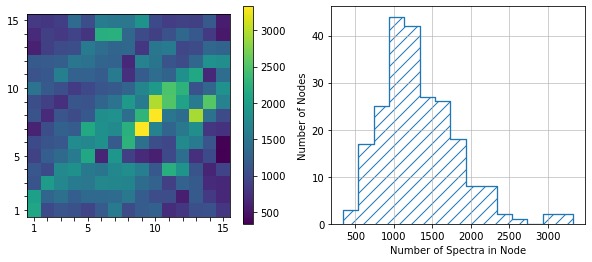

In [6]:
''' PLOT
Heightmap and distribution for test set'''

heightmap = np.zeros(num_nodes)
for i in range(num_nodes):
    bmu_mask = (y_test['bmu']==i)
    heightmap[i] = bmu_mask.sum()



fig,ax = plt.subplots(1,2,figsize=(10,4))

panel = ax[0].imshow(heightmap.reshape(map_size))
fig.colorbar(panel,ax=ax[0])

def plt_hist(axis, data, hatch, label):
    counts, edges = np.histogram(data, bins=int(len(data)**.5))
    edges = np.repeat(edges, 2)
    hist = np.hstack((0, np.repeat(counts, 2), 0))

    outline, = axis.plot(edges,hist,linewidth=1.3)        
    axis.fill_between(edges,hist,0,
                edgecolor=outline.get_color(), hatch = hatch, label = label,
                facecolor = 'none')
    axis.set_ylim(0, None, auto = True)

    
plt_hist(ax[1], heightmap, '//','unused')

ax[1].set_xlabel('Number of Spectra in Node')
ax[1].set_ylabel('Number of Nodes')
ax[1].grid(alpha=0.75)

def fix_ticks(arg_ax):
    arg_ax.set_xticks(range(15))
    arg_ax.set_xticklabels([1,'','','',5,'','','','',10,'','','','',15])
    arg_ax.set_yticks(range(15))
    arg_ax.set_yticklabels([15,'','','','',10,'','','','',5,'','','',1])
fix_ticks(ax[0])

print('heightmap min:',heightmap.min())
print('heightmap max:',heightmap.max())


done


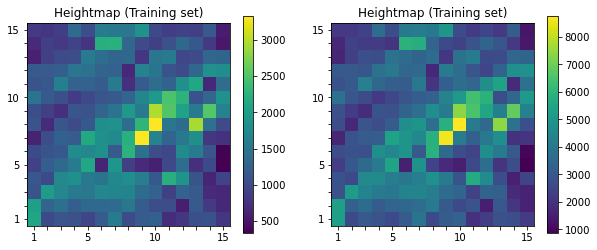

In [7]:

heightmap_test = np.zeros(num_nodes)
for i in range(num_nodes):
    bmu_mask = (y_test['bmu']==i)
    heightmap_test[i] = bmu_mask.sum()

heightmap_train = np.zeros(num_nodes)
for i in range(num_nodes):
    bmu_mask = (y_train['bmu']==i)
    heightmap_train[i] = bmu_mask.sum()


fig,ax = plt.subplots(1,2,figsize=(10,4))

panel = ax[0].imshow(heightmap_test.reshape(map_size))
fig.colorbar(panel,ax=ax[0])

panel = ax[1].imshow(heightmap_train.reshape(map_size))
fig.colorbar(panel,ax=ax[1])

ax[0].set_title('Heightmap (Training set)')
ax[1].set_title('Heightmap (Training set)')

fix_ticks(ax[0])
fix_ticks(ax[1])

print('done')

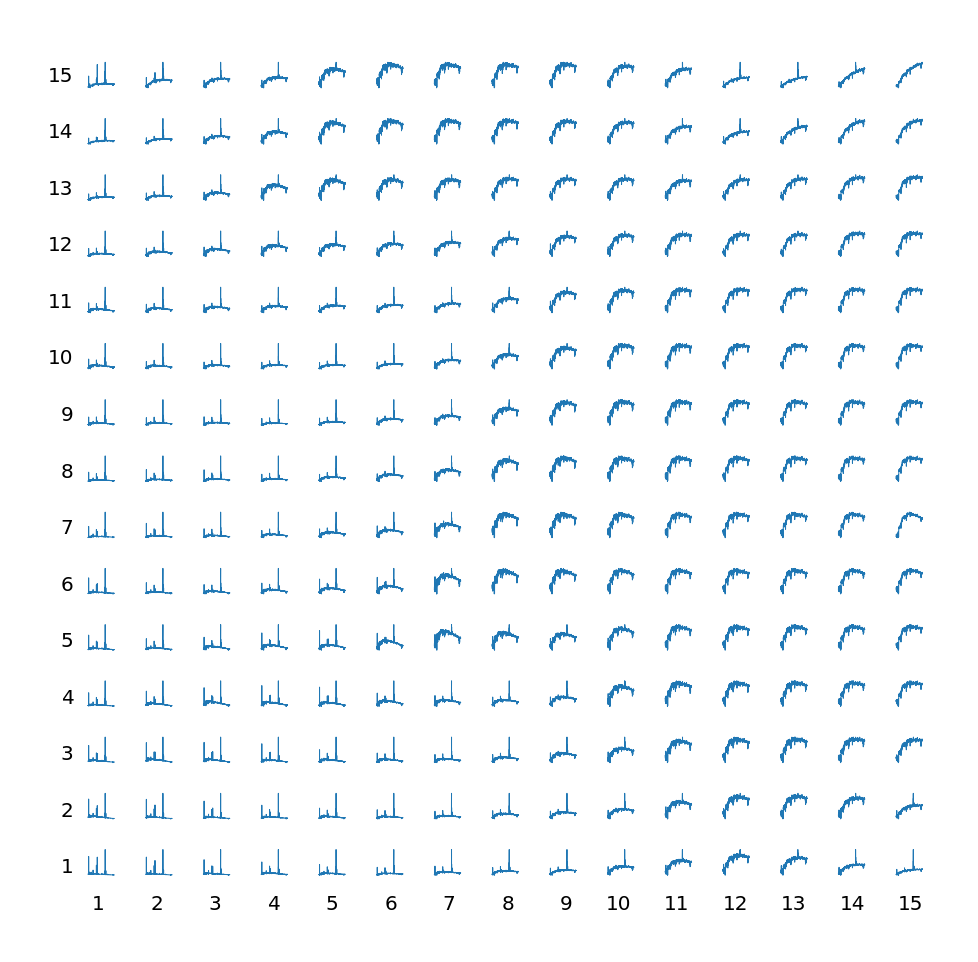

In [8]:
''' PLOT:
Decoded Prototypes of SOM1'''

decoded_prototypes = som.decode(som.prototypes)

fig, ax = plt.subplots(map_size[0], map_size[1], figsize=(15,15))
for k in range(num_nodes):
    x = decoded_prototypes[k]
    ax[k // map_size[1]][k % map_size[1]].plot(x,linewidth=1)
    ax[k // map_size[1]][k % map_size[1]].axis('off')
plt.subplots_adjust(hspace=1, wspace=1)

# this is the y axis
x_offset = (0.075,0.05)
x_step = 0.0587
for i in range(1,16):
    ax[0,0].annotate(i,
                xy=(x_offset[0], x_offset[1]+x_step*i), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='top',
                fontsize=20)

# this is the x axis
y_offset = (0.047,0.07)
y_step = 0.0598
for i in range(1,16):
    ax[0,0].annotate(i,
                xy=(y_offset[0]+y_step*i, y_offset[1]), xycoords='figure fraction',
                horizontalalignment='right', verticalalignment='top',
                fontsize=20)


  2%|▏         | 5/225 [00:01<01:13,  3.00it/s]/home/finnarch/jupyter_py3/lib/python3.6/site-packages/astropy/table/column.py:1152: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)
100%|██████████| 225/225 [01:24<00:00,  2.67it/s]


som1 parameters derived from training set


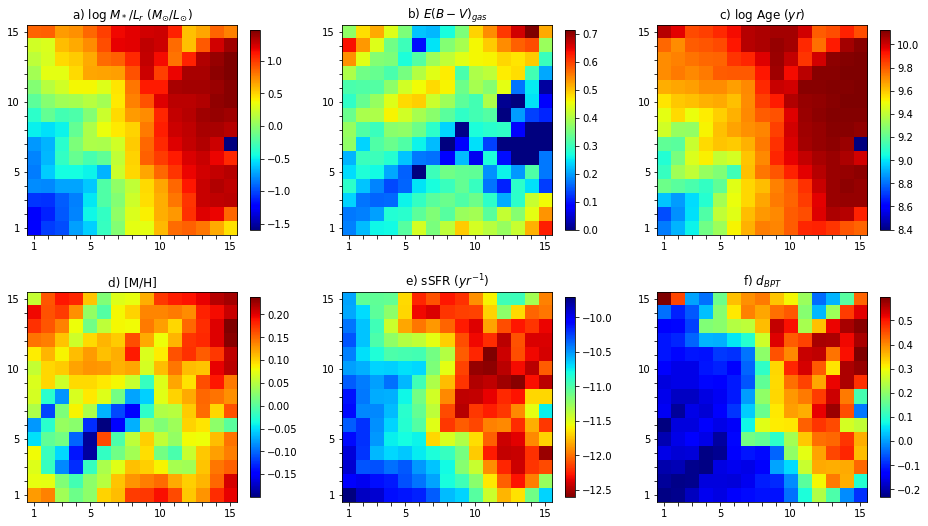

In [9]:
''' PLOT
SOM1 parameters given training set'''

# fill some arrays
arr_A_train = np.full(num_nodes,np.nan)
arr_B_train = np.full(num_nodes,np.nan)
arr_C_train = np.full(num_nodes,np.nan)
#
arr_D_train = np.full(num_nodes,np.nan)
arr_E_train = np.full(num_nodes,np.nan)
arr_F_train = np.full(num_nodes,np.nan)

for i in tqdm(range(num_nodes)):
    bmu_mask = (y_train['bmu']==i)
    bpt_mask = (y_train[bmu_mask]['min_sn_bpt'] > 3)
    ssfr_mask = (y_train[bmu_mask]['Halpha']/y_train[bmu_mask]['Halpha_Error'] > 2)
    
    arr_A_train[i] = np.log(np.nanmedian(y_train[bmu_mask]['ML_r']))
    arr_B_train[i] = np.nanmedian(y_train[bmu_mask]['ebv_gas'])
    arr_C_train[i] = np.nanmedian(y_train[bmu_mask]['logage'])
    
    arr_D_train[i] = np.nanmedian(y_train[bmu_mask]['met'])
    arr_E_train[i] = np.nanmedian(y_train[bmu_mask][ssfr_mask]['sSFR'])
    arr_F_train[i] = np.nanmedian(y_train[bmu_mask][bpt_mask]['BPTdist_Ka03'])
 
    
my_data_list_train = [arr_A_train.reshape(map_size), arr_B_train.reshape(map_size),
                      arr_C_train.reshape(map_size), arr_D_train.reshape(map_size),
                      arr_E_train.reshape(map_size), arr_F_train.reshape(map_size)]



names = [r'a) log $M_*/L_r$ $(M_{\odot}/L_{\odot})$',
         r'b) $E(B-V)_{gas}$',
         r'c) log Age $(yr)$',         
         r'd) [M/H]',
         r'e) sSFR $(yr^{-1})$',
         r'f) $d_{BPT}$',
        ]
param_table = Table(my_data_list_train, names=names)

my_data_list_train = list()
for i in names:
    my_data_list_train.append(param_table[i])


pc_kwargs = {'rasterized': True,}
my_cmaps = ['jet','jet','jet',
            'jet','jet_r','jet']

fig, axs = plt.subplots(2, 3, figsize=(16,9))

for data, title, ax, my_cmap in zip(my_data_list_train, names, axs.flat, my_cmaps):
    if title == r'i) $E(B-V)_{gas}$':
        temp_data = np.zeros((15,15))
        temp_data[:] = data
        mean = np.median(temp_data)
        std = np.std(temp_data)
        temp_data = np.clip(temp_data,0,mean+3*std)
        pc = ax.imshow(temp_data, **pc_kwargs,cmap=my_cmap)
    else:
        pc = ax.imshow(data, **pc_kwargs, cmap=my_cmap)
    cbar = fig.colorbar(pc, ax=ax, shrink=0.9, pad=0.05)
    fix_ticks(ax)
    ax.set_title(title)

print('som1 parameters derived from training set')


100%|██████████| 225/225 [00:40<00:00,  5.56it/s]


som1 parameters derived from test set


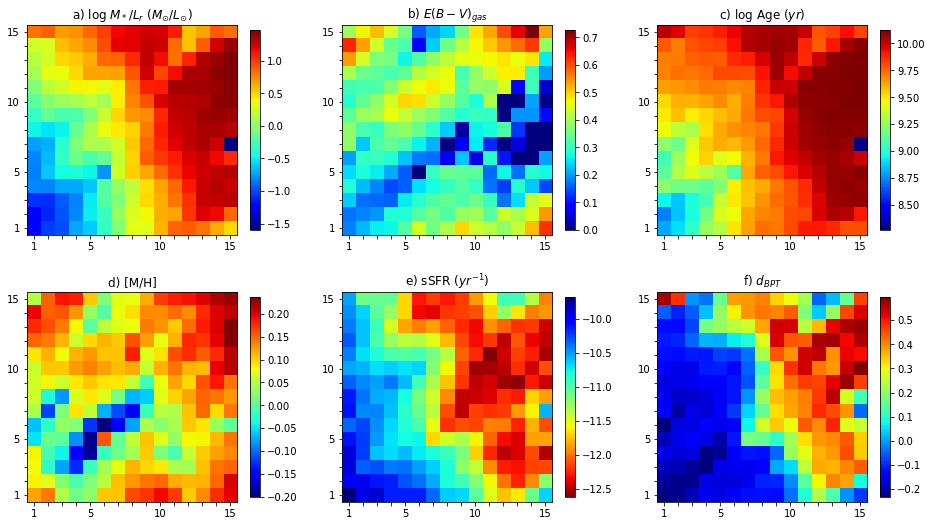

In [10]:

arr_A_test = np.full(num_nodes,np.nan)
arr_B_test = np.full(num_nodes,np.nan)
arr_C_test = np.full(num_nodes,np.nan)
#
arr_D_test = np.full(num_nodes,np.nan)
arr_E_test = np.full(num_nodes,np.nan)
arr_F_test = np.full(num_nodes,np.nan)

for i in tqdm(range(num_nodes)):
    bmu_mask = (y_test['bmu']==i)
    bpt_mask = (y_test[bmu_mask]['min_sn_bpt'] > 3)
    ssfr_mask = (y_test[bmu_mask]['Halpha']/y_test[bmu_mask]['Halpha_Error'] > 2)
    
    arr_A_test[i] = np.log(np.nanmedian(y_test[bmu_mask]['ML_r']))
    arr_B_test[i] = np.nanmedian(y_test[bmu_mask]['ebv_gas'])
    arr_C_test[i] = np.nanmedian(y_test[bmu_mask]['logage'])
    
    arr_D_test[i] = np.nanmedian(y_test[bmu_mask]['met'])
    arr_E_test[i] = np.nanmedian(y_test[bmu_mask][ssfr_mask]['sSFR'])
    arr_F_test[i] = np.nanmedian(y_test[bmu_mask][bpt_mask]['BPTdist_Ka03'])

my_data_list_test = [arr_A_test.reshape(map_size), arr_B_test.reshape(map_size),
                     arr_C_test.reshape(map_size), arr_D_test.reshape(map_size),
                     arr_E_test.reshape(map_size), arr_F_test.reshape(map_size)]



param_table = Table(my_data_list_test, names=names)

my_data_list_test = list()
for i in names:
    my_data_list_test.append(param_table[i])

pc_kwargs = {'rasterized': True,}
my_cmaps = ['jet','jet','jet',
            'jet','jet_r','jet']

fig, axs = plt.subplots(2, 3, figsize=(16,9))

for data, title, ax, my_cmap in zip(my_data_list_test, names, axs.flat, my_cmaps):
    if title == r'i) $E(B-V)_{gas}$':
        temp_data = np.zeros((15,15))
        temp_data[:] = data
        mean = np.median(temp_data)
        std = np.std(temp_data)
        temp_data = np.clip(temp_data,0,mean+3*std)
        pc = ax.imshow(temp_data, **pc_kwargs,cmap=my_cmap)
    else:
        pc = ax.imshow(data, **pc_kwargs, cmap=my_cmap)
    cbar = fig.colorbar(pc, ax=ax, shrink=0.9, pad=0.05)
    fix_ticks(ax)
    ax.set_title(title)

print('som1 parameters derived from test set')


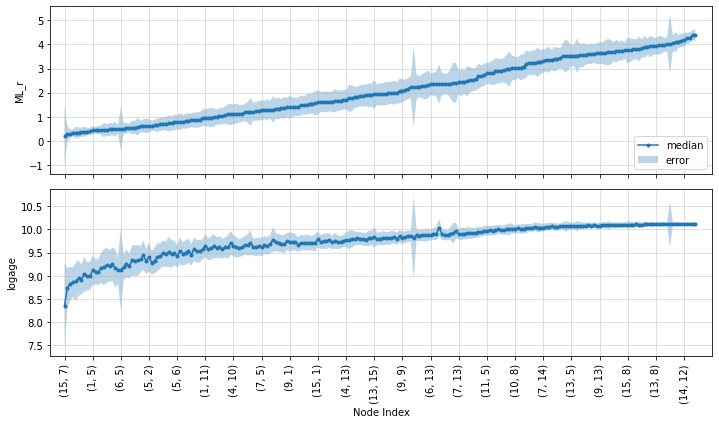

In [11]:
''' PLOT
Select two parameters, sort by median value of the first (ie sort ML_r by logage)'''

from astropy.table import vstack
my_data = vstack([y_test, y_train])


def node2idx(some_node, mapsize=15):
    row = int(some_node // mapsize)
    column = int(some_node % mapsize)
    return (column+1, mapsize-row) #inversed row indexes

def idx2node(index, mapsize=15): #index should be a tuple
    column_offset = (15-index[1]) * mapsize
    row_offset = index[0]-1
    return column_offset + row_offset

ATTR1= 'ML_r'
ATTR2= 'logage'

# calculate values and stddevs
z_mean1 = np.zeros(num_nodes)
z_std1 = np.zeros(num_nodes)
z_mean2 = np.zeros(num_nodes)
z_std2 = np.zeros(num_nodes)

for i in range(num_nodes):
    mask_train = (my_data['bmu']==i)

    z_mean1[i] = np.nanmedian(my_data[ATTR1][mask_train])
    z_std1[i] = np.nanstd(my_data[ATTR1][mask_train])
    #
    z_mean2[i] = np.nanmedian(my_data[ATTR2][mask_train])
    z_std2[i] = np.nanstd(my_data[ATTR2][mask_train])

# sort
merged_data = np.array((z_mean1,z_std1,
                        z_mean2,z_std2,
                        np.arange(num_nodes,dtype=int)))

merged_data = merged_data[:, merged_data[0, :].argsort()] #sort by attr1 median



# plot it
fig,(ax,ax2) = plt.subplots(2,1,figsize=(10,6),sharex=True)

ax.plot(merged_data[0],marker='.',label='median')
ax.fill_between(np.arange(num_nodes),merged_data[0]-merged_data[1],
               merged_data[0]+merged_data[1],alpha=0.3,label='error')


ax2.plot(merged_data[2],marker='.')
ax2.fill_between(np.arange(num_nodes),merged_data[2]-merged_data[3],
                 merged_data[2]+merged_data[3],alpha=0.3,label='error')
ax2.grid(alpha=0.5)
    
# format node locations
ax.set_xticks(np.arange(0, num_nodes, 10))
tuple_idx = list()
for i in range(num_nodes):
    tuple_idx.append(str(node2idx(merged_data[4][i])))
ax2.set_xticklabels(tuple_idx[::10],rotation=90)


ax.legend(loc='lower right')
ax.set_xlim(-5,num_nodes+5)
ax.grid(alpha=0.5)
ax.set_ylabel(ATTR1)
ax2.set_ylabel(ATTR2)
ax2.set_xlabel('Node Index')
plt.tight_layout()


node (9, 12) median: 1.2661 std: (0.5056)
node (2, 5) median: -0.5982 std: (0.2915)
node (10, 5) median: 0.8561 std: (0.5164)
node (8, 6) median: 0.5118 std: (0.4103)


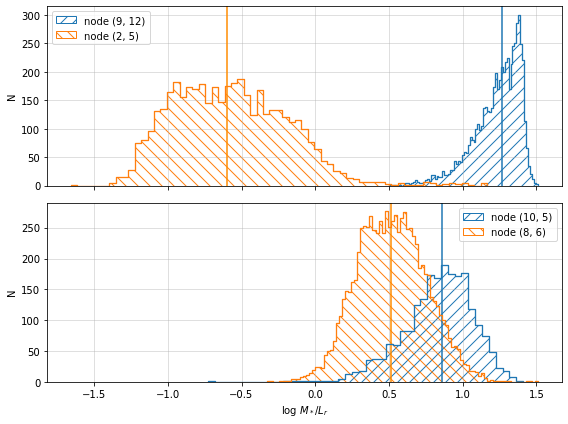

In [13]:

ATTR = 'ML_r'
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(8,6),sharex=True)

index = 53
mask = (my_data['bmu']==index)
d1a = np.log(my_data[ATTR][mask])
ax1.axvline(np.median(np.log(my_data[ATTR][mask])),ls='solid',c='tab:blue')
lab1a = 'node '+str(node2idx(index))
print('node '+str(node2idx(index))+' median: '+str(round(np.median(np.log(my_data[ATTR][mask])),4))+' std: ('+str(round(np.std(my_data[ATTR][mask]),4))+')')

index = 151
mask = (my_data['bmu']==index)
d1b = np.log(my_data[ATTR][mask])
ax1.axvline(np.median(np.log(my_data[ATTR][mask])),ls='solid',c='darkorange')
lab1b = 'node '+str(node2idx(index))
print('node '+str(node2idx(index))+' median: '+str(round(np.median(np.log(my_data[ATTR][mask])),4))+' std: ('+str(round(np.std(my_data[ATTR][mask]),4))+')')

index = 159
mask = (my_data['bmu']==index)
d2a = np.log(my_data[ATTR][mask])
ax2.axvline(np.median(np.log(my_data[ATTR][mask])),ls='solid',c='tab:blue')
lab2a = 'node '+str(node2idx(index))
print('node '+str(node2idx(index))+' median: '+str(round(np.median(np.log(my_data[ATTR][mask])),4))+' std: ('+str(round(np.std(my_data[ATTR][mask]),4))+')')

index = 142
mask = (my_data['bmu']==index)
d2b = np.log(my_data[ATTR][mask])
ax2.axvline(np.median(np.log(my_data[ATTR][mask])),ls='solid',c='darkorange')
lab2b = 'node '+str(node2idx(index))
print('node '+str(node2idx(index))+' median: '+str(round(np.median(np.log(my_data[ATTR][mask])),4))+' std: ('+str(round(np.std(my_data[ATTR][mask]),4))+')')


h1a = '//'
plt_hist(ax1,d1a,h1a,lab1a)

h1b = '\\\\'
plt_hist(ax1,d1b,h1b,lab1b)

h2a = '//'
plt_hist(ax2,d2a,h2a,lab2a)

h2b = '\\\\'
plt_hist(ax2,d2b,h2b,lab2b)

ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax1.legend()
ax2.legend()
ax1.set_ylabel('N')
ax2.set_ylabel('N')

plt.xlabel(r'log $M_*/L_r$')
plt.tight_layout()